### Single variable integration

In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

In [2]:
np.random.seed(32)

### Function Data Generation


In [3]:
def Line(samples):

    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = x

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Exp(samples):
    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = np.exp(x-1)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Inverse(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        xarr = np.arange(-1, 1.02, 1/50)
        x = np.random.uniform(-1, 1)
        y = 1 / (50*x)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

# --------------------------------------------------- #

def Square(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = x**2

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = False) , np.array(ydata, requires_grad = True)

#### Data Plotting

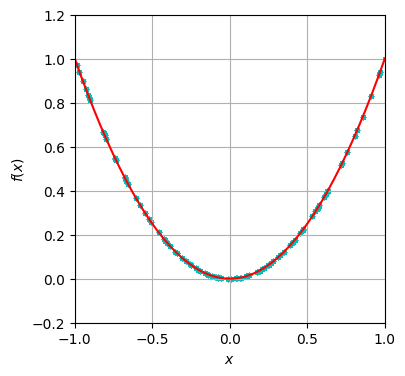

In [4]:
def plot_data(x, y, problem, fig = None, ax = None):
    
    if fig == None:
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
                               
    samples = len(x)
    xlin = np.linspace(-1, 1)

    for _ in range(samples):
        ax.scatter(x, y, alpha=0.5, color = 'c', s= 7)

    if problem == 'line':
        ax.plot(xlin, xlin, color = 'r')
        ax.set_ylim(top = 1.2, bottom = -1.2)

    if problem == 'exp':
        ax.plot(xlin, np.exp(xlin-1), color = 'r')
        ax.set_ylim(top = 1.2, bottom = -0.2)

    if problem == 'inverse':
        ax.plot(xlin, 1 / (50*xlin), color = 'r')
        ax.set_ylim(top = 1.5, bottom = -1.5)
    
    if problem == 'square':
        ax.plot(xlin, xlin**2, color = 'r')
        ax.set_ylim(top=1.2, bottom = -0.2)

    ax.set_xlim((-1,1))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.grid()

xdata, ydata = Square(100)
fig, ax = plt.subplots(figsize=(4, 4))
plot_data(xdata, ydata, 'square', fig, ax)


### VQC Model

In [5]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(params, xdata, num_qubits, num_layers):
    
    idx = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            qml.RY(params[idx], wires = i)
            qml.RZ(params[idx+1]*xdata, wires = i, id= 'Data Upload')
            qml.RZ(params[idx+2], wires = i)
            qml.RY(params[idx+3], wires = i)
            qml.RZ(params[idx+4], wires = i)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CRX(params[idx],[q, q+1])
                idx += 1
    
            if num_qubits > 2:
                qml.CRX(params[idx], [num_qubits-1, 0])
                idx += 1

    for i in range(num_qubits):
        qml.RY(params[-1-i], wires = i)
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
        obs @= qml.PauliZ(i+1)

    return qml.expval(obs)
# ------------------------------------------------- #
num_qubits = 4
num_layers = 1

params = np.random.uniform(size = num_qubits*(5*num_layers + num_layers + 1), requires_grad = True)
xdata = [1]

print(qml.draw(VQC_Model)(params, xdata[0], num_qubits, num_layers))
print(VQC_Model(params, xdata[0], num_qubits, num_layers))

0: ──RY(0.29)──RZ(0.39,"Data Upload")──RZ(0.13)──RY(0.21)──RZ(0.76)─╭●───────────────────────────
1: ──RY(0.58)──RZ(0.63,"Data Upload")──RZ(0.96)──RY(0.09)──RZ(0.13)─╰RX(0.76)─╭●─────────────────
2: ──RY(0.41)──RZ(0.22,"Data Upload")──RZ(0.53)──RY(0.83)──RZ(0.60)───────────╰RX(0.28)─╭●───────
3: ──RY(0.19)──RZ(0.38,"Data Upload")──RZ(0.28)──RY(0.70)──RZ(0.25)─────────────────────╰RX(0.05)

──╭RX(0.94)──RY(0.99)─┤ ╭<Z@Z@Z@Z>
──│──────────RY(0.60)─┤ ├<Z@Z@Z@Z>
──│──────────RY(0.74)─┤ ├<Z@Z@Z@Z>
──╰●─────────RY(0.52)─┤ ╰<Z@Z@Z@Z>
0.0005466174139617981


### Cost function

In [6]:
def cost_function(params, xdata, num_qubits, num_layers, ydata):
    loss = 0.0

    for i in range(len(xdata)):
        pred = VQC_Model(params, xdata[i], num_qubits, num_layers)
        loss += ((pred - ydata[i]))**2

    return loss / len(xdata)

### Circuit Executing

In [7]:
def model_running(params, xdata, num_qubits, num_layers):

    prediction = []

    for i in range(len(xdata)):
        pred = VQC_Model(params, xdata[i], num_qubits, num_layers)
        prediction.append(pred)

    return np.array(prediction)

### Utility

In [8]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [9]:
def iterate_minibatches(inputs, targets, batch_size):
    
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-----

In [10]:
### Preparing datas
train_data, train_target = Inverse(100)
test_data, test_target = Inverse(400)

# Ansatz Setting
num_qubits = 4
num_layers = 2

# Trainnig option settings
epochs = 100
batch_size = 25
lr = 0.05

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
params = np.random.uniform(size = num_qubits*(5*num_layers + num_layers + 1), requires_grad = True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(params, train_data, num_qubits, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(params, test_data, num_qubits, num_layers)
ratio_test, score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(params, test_data, num_qubits, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        params, _, _, _, _ = opt.step(cost_function, params, Xbatch, num_qubits, num_layers, ybatch)

    pred_train = model_running(params, train_data, num_qubits, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(params, train_data, num_qubits, num_layers, train_target)

    pred_test = model_running(params, test_data, num_qubits, num_layers)
    ratio_test, score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 0.418122 | Train accuracy: 0.020000 | Test Accuracy: 0.037500
Epoch:  1 | Loss: 2.378063 | Train accuracy: 0.020000 | Test accuracy: 0.022500
Epoch:  2 | Loss: 2.371091 | Train accuracy: 0.040000 | Test accuracy: 0.037500
Epoch:  3 | Loss: 2.355739 | Train accuracy: 0.060000 | Test accuracy: 0.020000
Epoch:  4 | Loss: 2.338796 | Train accuracy: 0.030000 | Test accuracy: 0.032500
Epoch:  5 | Loss: 2.324749 | Train accuracy: 0.070000 | Test accuracy: 0.090000
Epoch:  6 | Loss: 2.312042 | Train accuracy: 0.060000 | Test accuracy: 0.085000
Epoch:  7 | Loss: 2.299792 | Train accuracy: 0.020000 | Test accuracy: 0.050000
Epoch:  8 | Loss: 2.286218 | Train accuracy: 0.010000 | Test accuracy: 0.047500
Epoch:  9 | Loss: 2.272307 | Train accuracy: 0.040000 | Test accuracy: 0.032500
Epoch: 10 | Loss: 2.258227 | Train accuracy: 0.010000 | Test accuracy: 0.055000
Epoch: 11 | Loss: 2.246135 | Train accuracy: 0.040000 | Test accuracy: 0.060000
Epoch: 12 | Loss: 2.232440 | Train accur

----

### Checking Results

Cost: 2.146273 | Train accuracy 0.150000 | Test Accuracy : 0.112500
Learned weights
0: ──RY(1.34)──RZ(5.38,"Data Upload")──RZ(0.30)──RY(-0.43)──RZ(0.62)─╭●───────────────────
1: ──RY(1.28)──RZ(4.01,"Data Upload")──RZ(0.99)──RY(0.34)───RZ(0.55)─╰RX(-0.30)─╭●────────
2: ──RY(1.31)──RZ(4.67,"Data Upload")──RZ(0.41)──RY(-0.47)──RZ(0.82)────────────╰RX(-1.31)
3: ──RY(1.43)──RZ(5.72,"Data Upload")──RZ(0.02)──RY(-0.02)──RZ(0.37)──────────────────────

─────────────╭RX(0.49)──RY(-0.25)──RZ(4.05,"Data Upload")──RZ(1.10)───RY(-0.06)──RZ(0.71)─╭●───────
─────────────│──────────RY(-0.48)──RZ(3.62,"Data Upload")──RZ(0.89)───RY(0.43)───RZ(0.44)─╰RX(0.01)
──╭●─────────│──────────RY(0.25)───RZ(5.31,"Data Upload")──RZ(0.99)───RY(0.93)───RZ(0.71)──────────
──╰RX(-0.78)─╰●─────────RY(0.53)───RZ(6.05,"Data Upload")──RZ(-0.02)──RY(1.28)───RZ(0.72)──────────

──────────────────────╭RX(0.04)──RY(0.64)──┤ ╭<Z@Z@Z@Z>
──╭●──────────────────│──────────RY(1.18)──┤ ├<Z@Z@Z@Z>
──╰RX(0.32)─╭●────────│──────────RY(0.

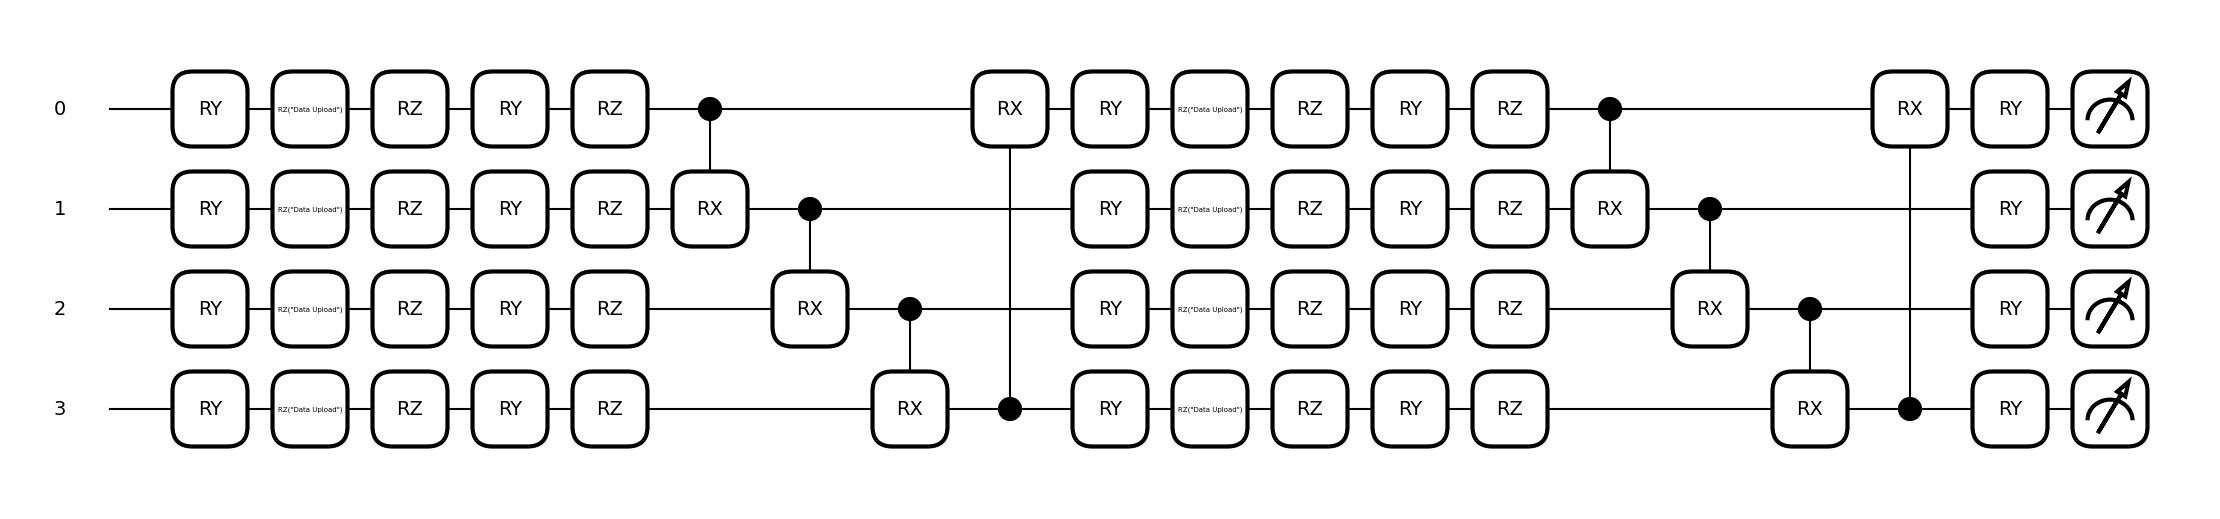

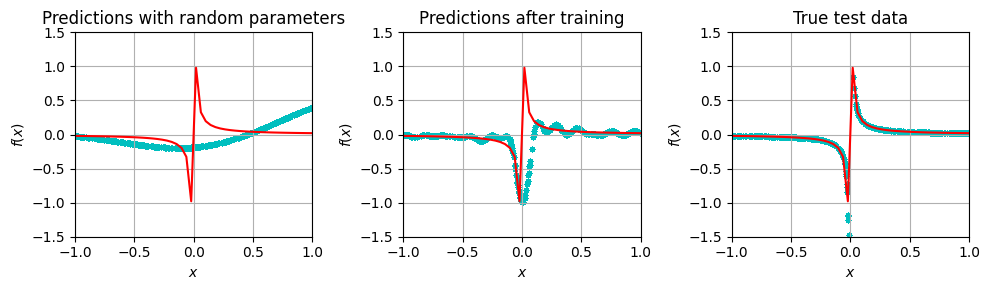

In [13]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
x = 1
print(qml.draw(VQC_Model)(params, x, num_qubits, num_layers))
fig, ax = qml.draw_mpl(VQC_Model)(params, x, num_qubits, num_layers)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot_data(x, y, problem, fig = None, ax = None)
plot_data(test_data, initial_predictions, 'inverse', fig, axes[0])
plot_data(test_data, pred_test, 'inverse' ,fig, axes[1])
plot_data(test_data, test_target, 'inverse' ,fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

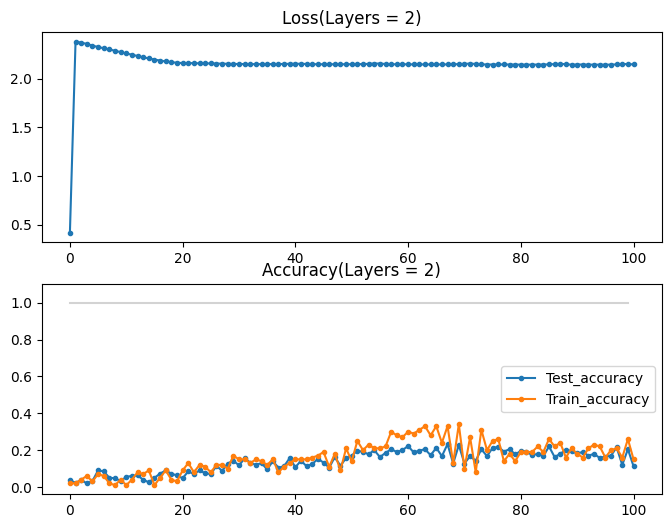

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
limit = [1]*epochs

axes[0].plot(loss_list,'.-')
axes[0].set_title(f"Loss(Layers = {num_layers})")

axes[1].plot(limit, '-', c = 'lightgray')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[1].legend()
axes[1].set_ylim(top = 1.1)
axes[1].set_title(f"Accuracy(Layers = {num_layers})")

plt.show()

-----